# Test our model weights on images and videos

The following code was originally run in google colab and adapted from two resources which can be found [here](https://www.youtube.com/watch?v=_FNfRtXEbr4&amp%3Bab_channel=Pysource) and [here](https://www.youtube.com/watch?v=zJDUhGL26iU&amp%3Bt=300s&amp%3Bab_channel=TheAIGuy).

In [ ]:
#check if NVIDIA GPU is enabled
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Sun Dec  6 00:01:16 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    23W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#connect google colab with google drive.
from google.colab import drive
drive.mount('/content/gdrive')

!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls /mydrive

## Clone the Darknet repo

In [ ]:
!git clone https://github.com/AlexeyAB/darknet

Cloning into 'darknet'...
remote: Enumerating objects: 14562, done.
remote: Total 14562 (delta 0), reused 0 (delta 0), pack-reused 14562
Receiving objects: 100% (14562/14562), 13.19 MiB | 11.76 MiB/s, done.
Resolving deltas: 100% (9910/9910), done.


## Compile Darknet using Nvidia GPU

In [ ]:
#change makefile to have GPU and OPENCV enabled
%cd darknet

!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!make

/content/darknet
mkdir -p ./obj/
mkdir -p backup
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:926:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
                 float rgb[3];
                       ^~~
./src/image_opencv.cpp: In function ‘void draw_train_loss(char*, void**, int, float, float, int, int, float, int, char*, float, int, int, double)’:
./src/image_opencv.cpp:1127:13: warning: this ‘if’ clause does not guard... [-Wmisleading-indentation]
             if (iteration_old == 0)
           

In [ ]:
#add the classes info
!echo "kick\npunch\nknee\nelbow\nclinch\nstance" > data/obj.names
!echo -e 'classes= 6\ntrain  = data/train.txt\nvalid  = data/test.txt\nnames = data/obj.names\nbackup = /mydrive/yolov3_multiclass_v2' > data/obj.data
!mkdir data/obj

## Configure Darknet network for testing YOLO V3

In [ ]:
#need to convert .cfg file to test mode
#make a copy of the confiuration file to make changes to
!cp cfg/yolov3.cfg cfg/yolov3_testing.cfg

In [ ]:
!sed -i 's/max_batches=500200/max_batches=8000/' cfg/yolov3_testing.cfg
!sed -i 's/steps=400000,450000/steps=6400,7200/' cfg/yolov3_testing.cfg
!sed -i '610 s@classes=80@classes=6@' cfg/yolov3_testing.cfg
!sed -i '696 s@classes=80@classes=6@' cfg/yolov3_testing.cfg
!sed -i '783 s@classes=80@classes=6@' cfg/yolov3_testing.cfg
!sed -i '603 s@filters=255@filters=33@' cfg/yolov3_testing.cfg
!sed -i '689 s@filters=255@filters=33@' cfg/yolov3_testing.cfg
!sed -i '776 s@filters=255@filters=33@' cfg/yolov3_testing.cfg

# Test the model on an image

In [ ]:
#helper function to display the image
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()

 CUDA-version: 10010 (10010), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 700, cudnn_half = 0, GPU: Tesla V100-SXM2-16GB 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5,  wt = 0, wn = 0, outputs: 104 x 104 x

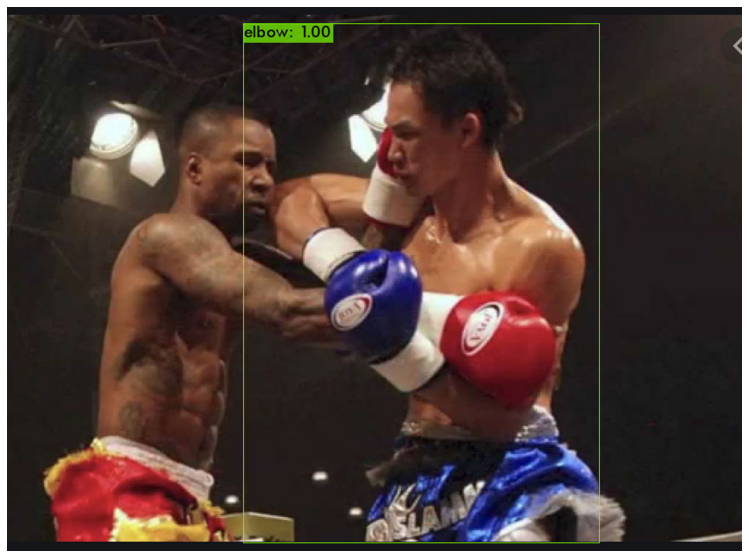

In [ ]:
!./darknet detector test data/obj.data cfg/yolov3_testing.cfg /mydrive/yolov3_multiclass_v2/yolov3_training_12000.weights /mydrive/yolov3_multiclass_v2/elbow_test.jpg -thresh 0.3
imShow('predictions.jpg')

 CUDA-version: 10010 (10010), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 700, cudnn_half = 0, GPU: Tesla V100-SXM2-16GB 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5,  wt = 0, wn = 0, outputs: 104 x 104 x

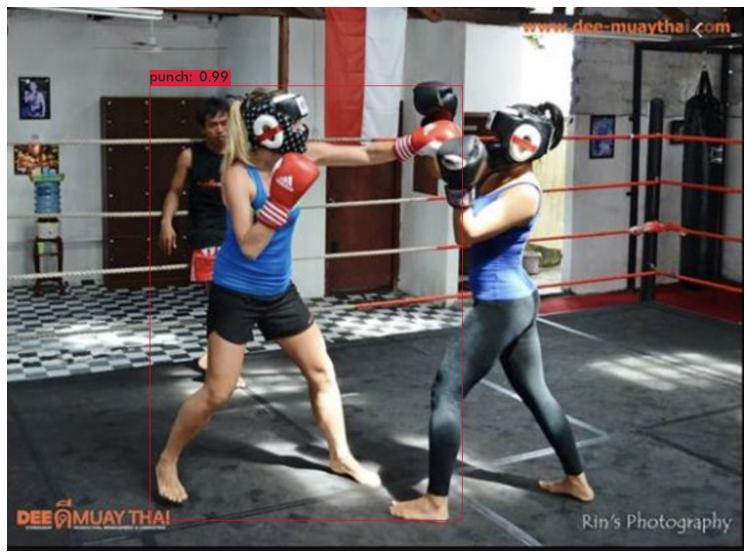

In [ ]:
!./darknet detector test data/obj.data cfg/yolov3_testing.cfg /mydrive/yolov3_multiclass_v2/yolov3_training_12000.weights /mydrive/yolov3_multiclass_v2/punch_test.jpg -thresh 0.3
imShow('predictions.jpg')

 CUDA-version: 10010 (10010), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 600, cudnn_half = 0, GPU: Tesla P100-PCIE-16GB 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5,  wt = 0, wn = 0, outputs: 104 x 104 x

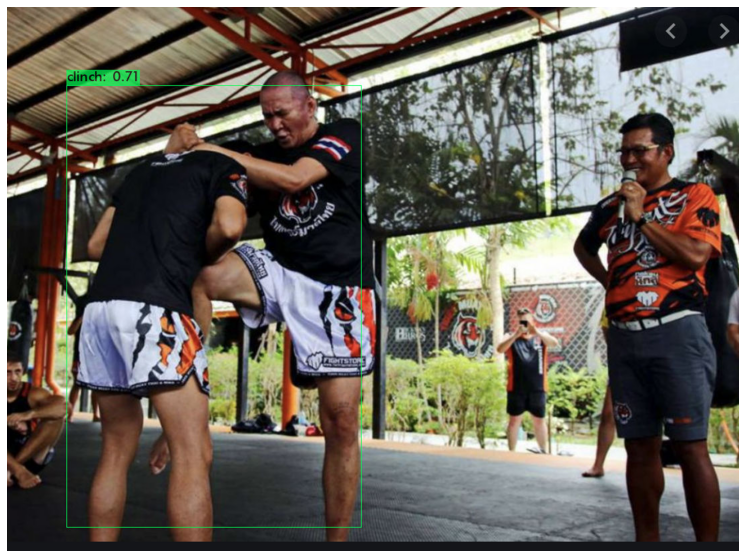

In [ ]:
!./darknet detector test data/obj.data cfg/yolov3_testing.cfg /mydrive/yolov3_multiclass_v2/yolov3_training_12000.weights /mydrive/yolov3_multiclass_v2/knee_test.jpg -thresh 0.3
imShow('predictions.jpg')

 CUDA-version: 10010 (10010), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 600, cudnn_half = 0, GPU: Tesla P100-PCIE-16GB 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5,  wt = 0, wn = 0, outputs: 104 x 104 x

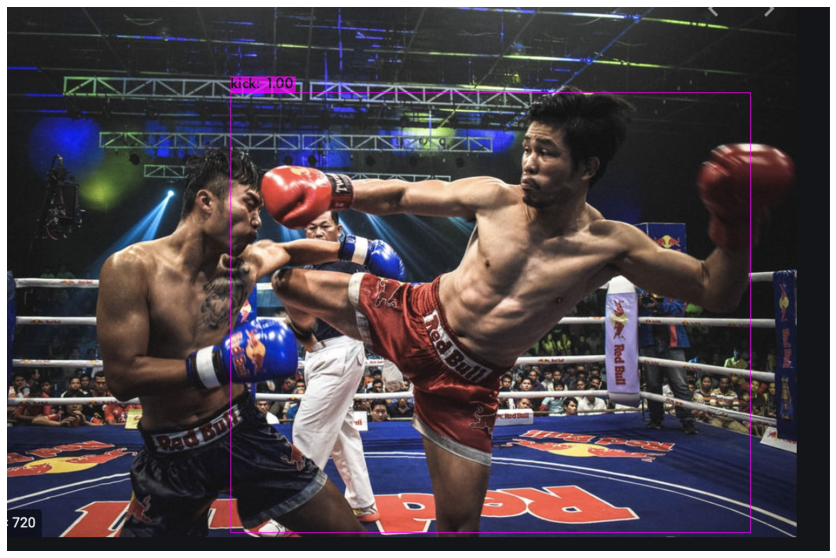

In [ ]:
!./darknet detector test data/obj.data cfg/yolov3_testing.cfg /mydrive/yolov3_multiclass_v2/yolov3_training_12000.weights /mydrive/yolov3_multiclass_v2/kick_test1.jpg -thresh 0.3
imShow('predictions.jpg')

 CUDA-version: 10010 (10010), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 600, cudnn_half = 0, GPU: Tesla P100-PCIE-16GB 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5,  wt = 0, wn = 0, outputs: 104 x 104 x

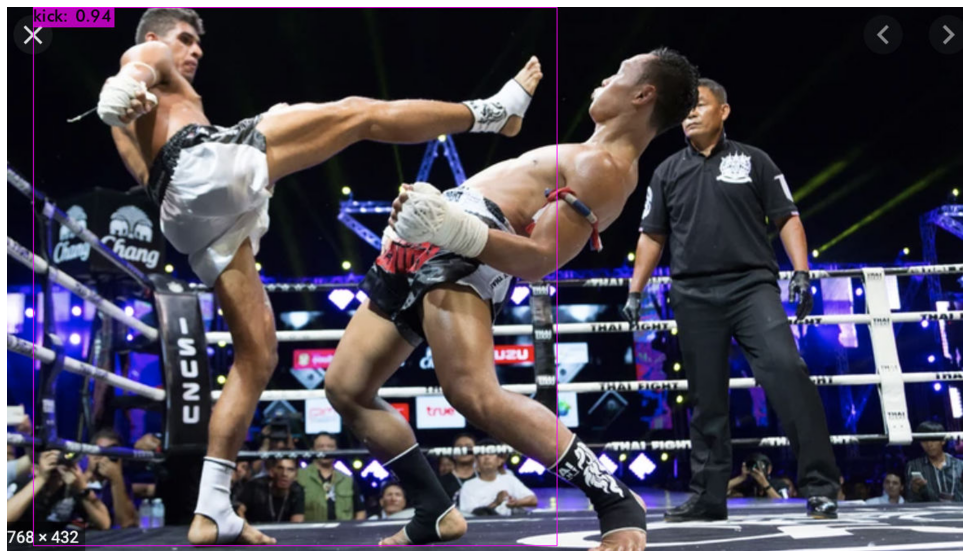

In [ ]:
!./darknet detector test data/obj.data cfg/yolov3_testing.cfg /mydrive/yolov3_multiclass_v2/yolov3_training_12000.weights /mydrive/yolov3_multiclass_v2/kick_test2.jpg -thresh 0.3
imShow('predictions.jpg')

# Test the model on a video

In [ ]:
!./darknet detector demo data/obj.data cfg/yolov3_testing.cfg /mydrive/yolov3_multiclass_v2/yolov3_training_12000.weights -dont_show /mydrive/yolov3_multiclass_v2/Tiffany_V_Esma.mp4 -thresh 0.5 -out_filename results.avi
#imShow('predictions.jpg')

Streaming output truncated to the last 5000 lines.
stance: 99% 
stance: 99% 

FPS:32.8 	 AVG_FPS:28.8

 cvWriteFrame 
Objects:

stance: 99% 
stance: 98% 

FPS:33.7 	 AVG_FPS:28.8

 cvWriteFrame 
Objects:

stance: 99% 
stance: 98% 

FPS:33.4 	 AVG_FPS:28.8

 cvWriteFrame 
Objects:

stance: 99% 
stance: 98% 

FPS:34.7 	 AVG_FPS:28.8

 cvWriteFrame 
Objects:

stance: 99% 
stance: 98% 

FPS:34.1 	 AVG_FPS:28.8

 cvWriteFrame 
Objects:

stance: 99% 
stance: 96% 

FPS:35.6 	 AVG_FPS:28.8

 cvWriteFrame 
Objects:

stance: 99% 
stance: 96% 

FPS:36.1 	 AVG_FPS:28.8

 cvWriteFrame 
Objects:

stance: 100% 
stance: 97% 

FPS:36.5 	 AVG_FPS:28.8

 cvWriteFrame 
Objects:

stance: 100% 
stance: 97% 

FPS:35.9 	 AVG_FPS:28.8

 cvWriteFrame 
Objects:

stance: 100% 
stance: 97% 

FPS:36.2 	 AVG_FPS:28.8

 cvWriteFrame 
Objects:

stance: 100% 
stance: 96% 

FPS:34.6 	 AVG_FPS:28.8

 cvWriteFrame 
Objects:

stance: 100% 
stance: 96% 

FPS:34.5 	 AVG_FPS:28.8

 cvWriteFrame 
Objects:

stance: 100% 
stance

In [ ]:
!./darknet detector demo data/obj.data cfg/yolov3_testing.cfg /mydrive/yolov3_multiclass/yolov3_training_last.weights -dont_show /mydrive/yolov3_multiclass/Saenchai_V_Shan_Cangelosi.mp4 -out_filename results.avi


Streaming output truncated to the last 5000 lines.
FPS:29.2 	 AVG_FPS:33.0

 cvWriteFrame 
Objects:


FPS:29.0 	 AVG_FPS:33.0

 cvWriteFrame 
Objects:


FPS:28.6 	 AVG_FPS:33.0

 cvWriteFrame 
Objects:


FPS:28.2 	 AVG_FPS:33.0

 cvWriteFrame 
Objects:


FPS:28.2 	 AVG_FPS:33.0

 cvWriteFrame 
Objects:


FPS:27.4 	 AVG_FPS:33.0

 cvWriteFrame 
Objects:


FPS:28.3 	 AVG_FPS:33.0

 cvWriteFrame 
Objects:


FPS:28.7 	 AVG_FPS:33.0

 cvWriteFrame 
Objects:


FPS:28.8 	 AVG_FPS:33.0

 cvWriteFrame 
Objects:


FPS:30.7 	 AVG_FPS:33.0

 cvWriteFrame 
Objects:


FPS:31.3 	 AVG_FPS:33.0

 cvWriteFrame 
Objects:


FPS:30.6 	 AVG_FPS:33.0

 cvWriteFrame 
Objects:


FPS:32.2 	 AVG_FPS:33.0

 cvWriteFrame 
Objects:


FPS:31.6 	 AVG_FPS:33.0

 cvWriteFrame 
Objects:


FPS:31.6 	 AVG_FPS:33.0

 cvWriteFrame 
Objects:


FPS:32.7 	 AVG_FPS:33.0

 cvWriteFrame 
Objects:


FPS:34.6 	 AVG_FPS:33.0

 cvWriteFrame 
Objects:


FPS:36.2 	 AVG_FPS:33.0

 cvWriteFrame 
Objects:

punch: 42% 

FPS:35.7 	 AVG_FPS:

In [ ]:
!./darknet detector demo data/obj.data cfg/yolov3_testing.cfg /mydrive/yolov3_multiclass_v2/yolov3_training_12000.weights -dont_show /mydrive/yolov3_multiclass_v2/trimmed_saenchai.mp4 -out_filename results.avi


Streaming output truncated to the last 5000 lines.
stance: 99% 
stance: 99% 

FPS:28.5 	 AVG_FPS:30.1

 cvWriteFrame 
Objects:

stance: 99% 
stance: 99% 

FPS:29.3 	 AVG_FPS:30.1

 cvWriteFrame 
Objects:

stance: 100% 
stance: 98% 

FPS:29.4 	 AVG_FPS:30.1

 cvWriteFrame 
Objects:

stance: 100% 
stance: 98% 

FPS:29.5 	 AVG_FPS:30.1

 cvWriteFrame 
Objects:

stance: 99% 
stance: 99% 

FPS:30.1 	 AVG_FPS:30.1

 cvWriteFrame 
Objects:

stance: 100% 
stance: 99% 

FPS:29.9 	 AVG_FPS:30.1

 cvWriteFrame 
Objects:

stance: 100% 
stance: 99% 

FPS:29.1 	 AVG_FPS:28.9

 cvWriteFrame 
Objects:

stance: 99% 
stance: 99% 

FPS:28.5 	 AVG_FPS:28.9

 cvWriteFrame 
Objects:

stance: 99% 
stance: 99% 

FPS:28.7 	 AVG_FPS:28.9

 cvWriteFrame 
Objects:

stance: 99% 
stance: 99% 

FPS:29.0 	 AVG_FPS:28.9

 cvWriteFrame 
Objects:

stance: 99% 
stance: 99% 

FPS:29.6 	 AVG_FPS:28.9

 cvWriteFrame 
Objects:

stance: 99% 
stance: 99% 

FPS:29.0 	 AVG_FPS:28.9

 cvWriteFrame 
Objects:

stance: 99% 
stance: 

In [ ]:
!./darknet detector demo data/obj.data cfg/yolov3_testing.cfg /mydrive/yolov3_multiclass_v2/yolov3_training_12000.weights -dont_show /mydrive/yolov3_multiclass_v2/Nathalie_V_Mariah_og.mp4 -thresh 0.51 -out_filename results.avi


Streaming output truncated to the last 5000 lines.
clinch: 75% 

FPS:25.4 	 AVG_FPS:23.2

 cvWriteFrame 
Objects:

punch: 99% 

FPS:25.8 	 AVG_FPS:23.2

 cvWriteFrame 
Objects:

punch: 99% 

FPS:26.0 	 AVG_FPS:23.2

 cvWriteFrame 
Objects:


FPS:25.7 	 AVG_FPS:23.2

 cvWriteFrame 
Objects:


FPS:25.9 	 AVG_FPS:23.2

 cvWriteFrame 
Objects:

stance: 95% 

FPS:25.2 	 AVG_FPS:23.2

 cvWriteFrame 
Objects:

stance: 95% 

FPS:25.2 	 AVG_FPS:23.2

 cvWriteFrame 
Objects:

stance: 96% 

FPS:25.3 	 AVG_FPS:23.2

 cvWriteFrame 
Objects:

stance: 68% 

FPS:25.9 	 AVG_FPS:23.2

 cvWriteFrame 
Objects:

stance: 68% 

FPS:25.9 	 AVG_FPS:23.2

 cvWriteFrame 
Objects:

clinch: 83% 

FPS:25.0 	 AVG_FPS:23.2

 cvWriteFrame 
Objects:

clinch: 83% 

FPS:24.9 	 AVG_FPS:23.2

 cvWriteFrame 
Objects:

clinch: 84% 

FPS:24.4 	 AVG_FPS:23.2

 cvWriteFrame 
Objects:

clinch: 99% 

FPS:25.3 	 AVG_FPS:23.2

 cvWriteFrame 
Objects:

clinch: 98% 

FPS:25.6 	 AVG_FPS:23.2

 cvWriteFrame 
Objects:


FPS:25.5 	 AVG_F

# Try a different amount of weights, in case it was overfit

In [ ]:
!./darknet detector demo data/obj.data cfg/yolov3_testing.cfg /mydrive/yolov3_multiclass/yolov3_training_10000.weights -dont_show /mydrive/yolov3_multiclass/Tiffany_V_Esma.mp4 -out_filename results.avi
#imShow('predictions.jpg')

Streaming output truncated to the last 5000 lines.


FPS:35.6 	 AVG_FPS:29.8

 cvWriteFrame 
Objects:


FPS:34.2 	 AVG_FPS:29.8

 cvWriteFrame 
Objects:


FPS:33.3 	 AVG_FPS:29.8

 cvWriteFrame 
Objects:


FPS:32.7 	 AVG_FPS:29.8

 cvWriteFrame 
Objects:


FPS:31.3 	 AVG_FPS:29.8

 cvWriteFrame 
Objects:


FPS:31.2 	 AVG_FPS:29.8

 cvWriteFrame 
Objects:


FPS:29.8 	 AVG_FPS:29.8

 cvWriteFrame 
Objects:


FPS:31.7 	 AVG_FPS:29.8

 cvWriteFrame 
Objects:


FPS:31.6 	 AVG_FPS:29.8

 cvWriteFrame 
Objects:


FPS:32.3 	 AVG_FPS:29.8

 cvWriteFrame 
Objects:


FPS:31.7 	 AVG_FPS:29.8

 cvWriteFrame 
Objects:


FPS:30.3 	 AVG_FPS:29.8

 cvWriteFrame 
Objects:


FPS:29.7 	 AVG_FPS:29.8

 cvWriteFrame 
Objects:


FPS:28.8 	 AVG_FPS:29.8

 cvWriteFrame 
Objects:


FPS:30.0 	 AVG_FPS:29.8

 cvWriteFrame 
Objects:


FPS:31.6 	 AVG_FPS:29.8

 cvWriteFrame 
Objects:


FPS:32.3 	 AVG_FPS:29.8

 cvWriteFrame 
Objects:


FPS:32.1 	 AVG_FPS:29.8

 cvWriteFrame 
Objects:


FPS:31.3 	 AVG_FPS:29.8

 cvW

In [ ]:
!./darknet detector demo data/obj.data cfg/yolov3_testing.cfg /mydrive/yolov3_multiclass/yolov3_training_10000.weights -dont_show /mydrive/yolov3_multiclass/trimmed_saenchai.mp4 -out_filename results.avi


Streaming output truncated to the last 5000 lines.

FPS:35.8 	 AVG_FPS:29.4

 cvWriteFrame 
Objects:


FPS:34.8 	 AVG_FPS:29.4

 cvWriteFrame 
Objects:


FPS:35.4 	 AVG_FPS:29.4

 cvWriteFrame 
Objects:


FPS:36.7 	 AVG_FPS:29.4

 cvWriteFrame 
Objects:


FPS:37.2 	 AVG_FPS:29.4

 cvWriteFrame 
Objects:


FPS:37.0 	 AVG_FPS:29.4

 cvWriteFrame 
Objects:


FPS:38.2 	 AVG_FPS:29.4

 cvWriteFrame 
Objects:


FPS:37.5 	 AVG_FPS:29.4

 cvWriteFrame 
Objects:


FPS:36.6 	 AVG_FPS:29.4

 cvWriteFrame 
Objects:


FPS:36.2 	 AVG_FPS:29.4

 cvWriteFrame 
Objects:


FPS:37.6 	 AVG_FPS:29.4

 cvWriteFrame 
Objects:


FPS:37.6 	 AVG_FPS:29.4

 cvWriteFrame 
Objects:


FPS:35.8 	 AVG_FPS:29.4

 cvWriteFrame 
Objects:


FPS:35.4 	 AVG_FPS:29.4

 cvWriteFrame 
Objects:


FPS:34.2 	 AVG_FPS:29.4

 cvWriteFrame 
Objects:


FPS:35.3 	 AVG_FPS:29.4

 cvWriteFrame 
Objects:


FPS:35.4 	 AVG_FPS:29.4

 cvWriteFrame 
Objects:


FPS:33.6 	 AVG_FPS:29.4

 cvWriteFrame 
Objects:


FPS:33.7 	 AVG_FPS:29.4

 cvWr